# ASR post-processing corrector pred vs gold

## TRAIN

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import os, pickle
from multiprocessing import Pool
from Cfg import Cfg
from RecordingCorpus import RecordingCorpus
from tqdm.auto import tqdm
from SplitCorpus import SplitCorpus
from load_pretrained_model import load_pretrained_model
from listen_and_transcribe import listen_and_transcribe

## Load training examples

In [ ]:
if __name__=="__main__":
    language='vietnamese'
    phase='build'
    release='b30'
    C = Cfg('NIST', 16000, language, phase, release)
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

In [ ]:
splits=SplitCorpus.transcript_split(C, recordings)

In [ ]:
max_duration=33
model = load_pretrained_model(C, 0)

## For each BUILD subsplit match gold with pred of split audio

In [ ]:
pairs=[]

for artifact in splits.artifacts:
    gold=artifact.target.value
    audio=artifact.source.value
    transcript=listen_and_transcribe(C, model, max_duration, gold, audio)
    pred=' '.join([z for x,y,z in transcript])
    pairs.append((pred, gold))

In [ ]:
len([x for x,y in pairs if len(x)==0])

In [ ]:
pairs = [(x.lower(),y.lower()) for x,y in pairs if len(x)>0]

In [ ]:
len(pairs)

## Save training set

In [ ]:
training='\n'.join([f'{x.strip()}\t{y.strip()}' for x,y in pairs])

In [ ]:
error_correction_training_fn='foo.tsv'

In [ ]:
with open(error_correction_training_fn, 'w', encoding='utf-8') as f:
    f.write(training)

In [ ]:
training[0:100]

## Create consolidated vocabulary

In [ ]:
graphemes=list(sorted(set([x for x in training if x not in ['\n', '\t']])))

In [ ]:
graphemes=[' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
           'r','s','t','u','v','w','x','y','à','á','â','ã','è','é','ê','ì','í','ò',
           'ó','ô','õ','ù','ú','ý','ă','đ','ĩ','ũ','ơ','ư','ạ','ả','ấ','ầ','ẩ','ẫ',
           'ậ','ắ','ằ','ẳ','ẵ','ặ','ẹ','ẻ','ẽ','ế','ề','ể','ễ','ệ',
           'ỉ','ị','ọ','ỏ','ố','ồ','ổ','ỗ','ộ','ớ','ờ','ở','ỡ','ợ',
           'ụ','ủ','ứ','ừ','ử','ữ','ự','ỳ','ỷ','ỹ']

## Build model

In [ ]:
MAX_LENGTH=max([max(len(a), len(b)) for a,b in pairs])+50

In [ ]:
MAX_LENGTH=496

import random
import torch
from torchtext.data import Field, BucketIterator

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

## Data loader

from torchtext.data import Iterator

from torchtext.data import TabularDataset
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

## Model

MIN_FREQ=1

SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

from seq_to_seq import *

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

from count_parameters import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

import os


from initialize_weights import initialize_weights

model.apply(initialize_weights);
if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

## Trainer

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
model.train();

In [ ]:
batch_size=32
train_iterator = Iterator(train_data, batch_size=batch_size)

In [ ]:
print(f'{len(train_iterator)} batches / epoch')

In [ ]:
epoch_loss = 9999999999999999
j=0

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

def progress_bar(ax, progress):
    ax.plot(progress)
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')

In [ ]:
losses = []
while epoch_loss > 0.1:
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    j += 1
    losses.append(epoch_loss)
    progress_bar(ax, losses)

In [ ]:
!mkdir -p save/new_afterburner
model_fn='save/new_afterburner/afterburner_300.pt'
torch.save(model.state_dict(), model_fn)

## INFER

## Translate pred to gold and check WER

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, pickle, random, torch
from tqdm.auto import tqdm
from count_parameters import count_parameters
from initialize_weights import initialize_weights
from calculate_cer import calculate_cer
from calculate_wer import calculate_wer
from prediction_to_string import prediction_to_string
from torchtext.data import Field, BucketIterator
from torchtext.data import Iterator
from torchtext.data import TabularDataset
import torch.nn as nn
from seq_to_seq import *

In [3]:
error_correction_training_fn='foo.tsv'
model_fn='save/new_afterburner/afterburner_300.pt'

In [4]:
graphemes=[' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
           'r','s','t','u','v','w','x','y','à','á','â','ã','è','é','ê','ì','í','ò',
           'ó','ô','õ','ù','ú','ý','ă','đ','ĩ','ũ','ơ','ư','ạ','ả','ấ','ầ','ẩ','ẫ',
           'ậ','ắ','ằ','ẳ','ẵ','ặ','ẹ','ẻ','ẽ','ế','ề','ể','ễ','ệ',
           'ỉ','ị','ọ','ỏ','ố','ồ','ổ','ỗ','ộ','ớ','ờ','ở','ỡ','ợ',
           'ụ','ủ','ứ','ừ','ử','ữ','ự','ỳ','ỷ','ỹ']

In [ ]:
MAX_LENGTH=496
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [7]:
batch_size=32
train_iterator = Iterator(train_data, batch_size=batch_size)

In [5]:
## Model

MIN_FREQ=1

SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

model.apply(initialize_weights);
if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))
    print('reloaded trained model')

The model has 4,281,440 trainable parameters
reloaded trained model


In [8]:
model.eval();
R=[]
for i, batch in enumerate(tqdm(train_iterator)):
    src = batch.src.to(device)
    trg = batch.trg.to(device)
    output, _ = model(src, trg[:,:-1])
    output_dim = output.shape[-1]
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:,1:].contiguous().view(-1)   
    prediction=prediction_to_string(TRG, batch_size, output, False)
    gold=prediction_to_string(TRG, batch_size, trg, True)   
    for hyp,au in zip(prediction, gold):
        R.append((au,hyp,calculate_cer(hyp, au),calculate_wer(hyp, au)))

In [9]:
R=[(au.strip(), hyp.strip(), cer, wer) for au, hyp, cer, wer in R if '<pad>' not in au]

In [10]:
import pandas as pd
results=pd.DataFrame(R, columns=['Gold', 'Pred', 'CER', 'WER'])
results['GOLD_n_words']=results['Gold'].apply(lambda x: len(x.split(' ')))
results['GOLD_n_chars']=results['Gold'].apply(lambda x: len(x))
results['CER_pct']=results.CER/results['GOLD_n_chars']
results['WER_pct']=results.CER/results['GOLD_n_words']
results=results[results.Gold != '<pad>']
results

,Gold,Pred,CER,WER,GOLD_n_words,GOLD_n_chars,CER_pct,WER_pct
0,thế không thích đi ba không,thế không thích đi ba không,0,0,6,27,0.0,0.0
1,gì thì chú thì tuổi tuất thì cưới vợ sớm mà hô...,gì thì chú thì tuổi tuất thì cưới vợ sớm mà hô...,0,0,20,75,0.0,0.0
2,hản có thủy làm chi em chưa biết nhà cô thủy,hản có thủy làm chi em chưa biết nhà cô thủy,0,0,11,44,0.0,0.0
3,bởi vậy nó kén ăn á không có ăn không có đứa n...,bởi vậy nó kén ăn á không có ăn không có đứa n...,0,0,20,73,0.0,0.0
4,công việc thế nào rồi,công việc thế nào rồi,0,0,5,21,0.0,0.0
...,...,...,...,...,...,...,...,...
9237,ình là xsao,ình là xsao,0,0,3,11,0.0,0.0
9238,i,i,0,0,1,1,0.0,0.0
9239,vy vâ ba g,vy vâ ba g,0,0,4,10,0.0,0.0
9240,iờ của ông,iờ của ông,0,0,3,10,0.0,0.0


<IPython.core.display.Javascript object>


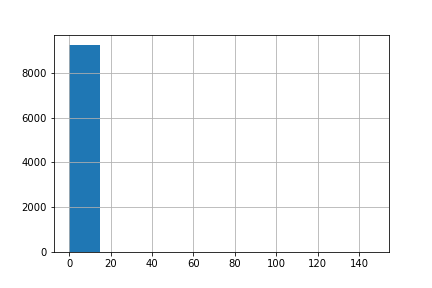

<AxesSubplot:>

In [11]:
%matplotlib notebook
results.WER_pct.hist(bins=10)

In [12]:
results.WER_pct.mean(), results.CER_pct.mean()

(0.07707691728475893, 0.04787298732657071)